In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid")
sns.set_theme()

In [39]:
df = pd.read_csv('transcriptomics_fractions.csv')
df1 = pd.read_csv('samples_transcriptomics.csv', index_col='Unnamed: 0').set_index('Sample.ID')
df2 = pd.read_csv('Ecoli_gene_functional_annotations.csv', encoding = 'cp1252', index_col='Unnamed: 0')

In [3]:
df_renamed = df.rename(columns={'Unnamed: 0': 'gene'})
df_T = df_renamed.set_index('gene')
df2_sorted = df2.dropna(subset=['gene']).sort_values(by='gene', ascending=True).reset_index(drop=True)
df2_s = df2_sorted.set_index('gene')

In [4]:
df_join = pd.merge(df2_s, df_T, left_index=True, right_index=True)

In [37]:
Alim = df_join.loc[:,:'a4_1'].sort_values(by='cog_functional_cat', ascending=True)
Clim = df_join.drop(df_join.columns[list(range(7,14)) + list(range(24, 35))], axis=1).sort_values(by='cog_functional_cat', ascending=True)
Rlim = df_join.drop(df_join.columns[7:24], axis=1).sort_values(by='cog_functional_cat', ascending=True)

In [59]:
def ffunctionality(group, functionality, a ,b):
    'a, b =  0, 7 for Alim_sor'
    'a, b =  7, 17 for Clim_sor'
    'a, b =  17, 28 for Rlim_sor'
    func = group['cog_functional_cat'].tolist()
    for raw in enumerate(func):
        group_func = group[group['cog_functional_cat']==str(functionality)]
        group_f= group_func.iloc[:,7:].T
        group_f['Growth.rate']= list(df1['Growth.rate..1.h.'][a:b])
        group_ff = group_f
    return pd.merge(df1[:][:7], group_ff, left_index=True, right_index=True)

In [66]:
AlimA = ffunctionality(Alim, 'A', 0 , 7)

In [71]:
AlimC = ffunctionality(Alim, 'C', 0 , 7)

In [68]:
AlimCE = ffunctionality(Alim, 'CE', 0 , 7)

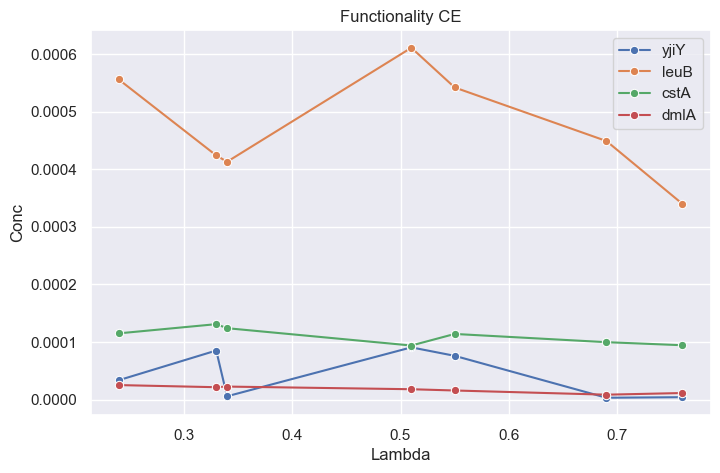

In [70]:
plt.figure(figsize=(8, 5))

for col in AlimCE.columns[9:-1]: 
    sns.lineplot(x=AlimCE['Growth.rate'], y=AlimCE[col], label=col, marker='o')

plt.xlabel('Lambda')
plt.ylabel('Conc')
plt.title('Functionality CE')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
def sepffuncionality(group, functionality, a, b):
    func = group['cog_functional_cat'].tolist()
    for i in func:
        a = ffunctionality(group, functionality, a ,b)

In [55]:
func

['A',
 'C',
 'CE',
 'CHR',
 'CIR',
 'CO',
 'CP',
 'CPO',
 'CR',
 'D',
 'DE',
 'DI',
 'DL',
 'DM',
 'DP',
 'DPM',
 'DZ',
 'E',
 'EF',
 'EG',
 'EH',
 'EHJQ',
 'EM',
 'EP',
 'EQ',
 'ER',
 'ET',
 'F',
 'FH',
 'FM',
 'FP',
 'FR',
 'FT',
 'FV',
 'G',
 'GER',
 'GH',
 'GI',
 'GK',
 'GM',
 'GP',
 'GT',
 'H',
 'HC',
 'HE',
 'HI',
 'HJ',
 'HO',
 'HQ',
 'HR',
 'HT',
 'HV',
 'I',
 'IQ',
 'IR',
 'J',
 'JE',
 'JHO',
 'JLK',
 'JO',
 'JR',
 'JV',
 'K',
 'KE',
 'KG',
 'KJ',
 'KL',
 'KN',
 'KT',
 'KV',
 'KX',
 'L',
 'LK',
 'LX',
 'M',
 'MG',
 'MN',
 'MO',
 'MR',
 'MT',
 'MU',
 'MV',
 'N',
 'NT',
 'NU',
 'NUW',
 'NW',
 'O',
 'OE',
 'OK',
 'OT',
 'OU',
 'P',
 'PH',
 'PO',
 'PQ',
 'PR',
 'PT',
 'PV',
 'Q',
 'QC',
 'QR',
 'R',
 'S',
 'T',
 'TE',
 'TG',
 'TK',
 'U',
 'UW',
 'V',
 'VI',
 'VT',
 'W',
 'X',
 'XT']

In [32]:
func = list(dict.fromkeys(Alim['cog_functional_cat'].tolist()))
for i in func:
    Alim1 = str('Alim') + str(i) 
    A = ffunctionality(Alim, i, 0, 7)
    print(Alim1)
    print(A)

AlimA
gene       orn      rtcA  Growth.rate
a1    0.000080  0.000012         0.69
a1_1  0.000131  0.000013         0.76
a2    0.000090  0.000015         0.51
a2_1  0.000108  0.000021         0.55
a3    0.000110  0.000016         0.33
a4    0.000117  0.000017         0.24
a4_1  0.000123  0.000017         0.34
AlimC
gene      dmsB      ybiW      nirB      nfsB      ycbX      nfsA      yccM  \
a1    0.000004  0.000003  0.000101  0.000256  0.000052  0.000043  0.000002   
a1_1  0.000012  0.000003  0.000981  0.000337  0.000039  0.000065  0.000002   
a2    0.000005  0.000005  0.000080  0.000232  0.000075  0.000048  0.000003   
a2_1  0.000008  0.000005  0.000469  0.000245  0.000071  0.000058  0.000004   
a3    0.000009  0.000006  0.000310  0.000239  0.000068  0.000043  0.000005   
a4    0.000008  0.000006  0.000207  0.000210  0.000082  0.000053  0.000004   
a4_1  0.000013  0.000006  0.000579  0.000205  0.000078  0.000055  0.000005   

gene      yccX      nemA      cbrA  ...      gldA      mdh 

KeyboardInterrupt: 

In [ ]:
func = list(dict.fromkeys(Alim['cog_functional_cat'].tolist()))

In [ ]:
cols_per_figure = 4 

for i in range(1, Alim.shape[1]-1, cols_per_figure):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
    axes = axes.flatten()  
    
    for j, col in enumerate(Alim.columns[i:i+cols_per_figure]):
        ax = axes[j]
        sns.lineplot(x=Alim['Growth.rate'], y=Alim[col], ax=ax, marker='o')
        ax.set_title(f'{col}')
        ax.set_xlabel('Lambda')
        ax.set_ylabel('Conc.')
    
    plt.tight_layout()
    plt.show()

In [ ]:
cols_per_figure = 4
RlimC = ffunctionality(Rlim_sor, str(for i in func: print(i) , 17, 28)

for i in range(0, RlimC.shape[1]-1, cols_per_figure):
    fig, axes = plt.subplots(nrows=1, ncols=Alim_fA.shape[1]-1, figsize=(16, 3))
    axes = axes.flatten()  
    
    for j, col in enumerate(Alim_fa.columns[i:i+cols_per_figure]):
        ax = axes[j]
        sns.lineplot(x=Alim_fa['Growth.rate'], y=Alim_fa[col], ax=ax, marker='o')
        ax.set_title(f'Alim - A- {col}')
        #ax.set_xlabel('Lambda')
        ax.set_ylabel('Conc.')
    
    plt.tight_layout()
    plt.show()

In [ ]:
df1_plus_AlimFa = df1[:][:7].merge(Alim_fa, how='inner', on='Sample.ID')
df1_plus_AlimFa

In [ ]:
Alim_Sumplement60 = df1_plus_AlimFa[df1_plus_AlimFa['Supplement']=='60 µM IPTG']
Alim_Sumplement40 = df1_plus_AlimFa[df1_plus_AlimFa['Supplement']=='40 µM IPTG']
Alim_Sumplement28 = df1_plus_AlimFa[df1_plus_AlimFa['Supplement']=='28 µM IPTG']
Alim_Sumplement20 = df1_plus_AlimFa[df1_plus_AlimFa['Supplement']=='20 µM IPTG']

In [ ]:
sns.scatterplot(x = Alim_fa['Growth.rate'], y = Alim_fa['rtcA']+Alim_fa['orn'], marker='o')
#sns.lineplot(x = Alim_fa['Growth.rate'], y = Alim_fa['orn'], marker='o')
#sns.lineplot(Alim_Sumplement28['Growth.rate'], df['orn'], marker='o')
#sns.lineplot(Alim_Sumplement20['Growth.rate'], df['orn'], marker='o')
plt.xlabel('Lambda')
plt.ylabel('Conc')
plt.title(f'Alim - A-')
plt.legend()
plt.show()

In [ ]:
cols_per_figure = 2

for i in range(0, Alim_fA.shape[1]-1, cols_per_figure):
    fig, axes = plt.subplots(nrows=1, ncols=Alim_fA.shape[1]-1, figsize=(16, 3))
    axes = axes.flatten()  
    
    for j, col in enumerate(Alim_fa.columns[i:i+cols_per_figure]):
        ax = axes[j]
        sns.lineplot(x=Alim_fa['Growth.rate'], y=Alim_fa[col], ax=ax, marker='o')
        ax.set_title(f'Alim - A- {col}')
        #ax.set_xlabel('Lambda')
        ax.set_ylabel('Conc.')
    
    plt.tight_layout()
    plt.show()

In [ ]:
 Alim_fA.shape[1]

In [ ]:
import pandas as pd

# Crear un DataFrame de ejemplo con 20 columnas
data = {f'Col{i}': range(1, 6) for i in range(1, 21)}
df = pd.DataFrame(data)

# Eliminar columnas del 5 al 8 (índices 4 a 7) y del 14 al 20 (índices 13 a 19)
df_filtrado = df.drop(df.columns[list(range(4, 8)) + list(range(13, 19))], axis=1)

print(df_filtrado)